In [26]:
#import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime as dt
from scipy.optimize import minimize 

In [27]:
# Define the start and end dates of stock prices
def get_data(name, start,end):
    # download data 
    df = web.DataReader(name, 'yahoo', start, end)
    df = df.sort_values(by='Date')
    return df

In [28]:
start_date = dt.datetime(2020, 9, 1)
end_date = dt.datetime(2022, 9, 1)
GM = get_data("GM", start=start_date, end=end_date)


In [57]:
training_set = GM.iloc[0:505 - 180, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = GM.iloc[505 - 180:, 2:3].values  # 后300天的开盘价作为测试集


In [73]:
GM[["Adj Close"]]

,Adj Close
Date,
2020-09-01,29.722141
2020-09-02,30.889475
2020-09-03,29.412848
2020-09-04,29.931664
2020-09-08,32.306244
...,...
2022-08-26,39.140636
2022-08-29,39.419998
2022-08-30,39.130001


In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [59]:

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

In [60]:

# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
       x_train.append(training_set_scaled[i - 60:i, 0])
       y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)


# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

In [66]:

model = tf.keras.Sequential([
    LSTM(80, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/rnn_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

-------------load the model-----------------
Train on 265 samples, validate on 120 samples
Epoch 1/50


2022-10-02 18:03:36.416994: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_26663_27148' and '__inference___backward_standard_lstm_26663_27148_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_27237' both implement 'lstm_1217f616-c6ba-48ed-b55d-21f611e6570b' but their signatures do not match.


256/265 [===========================>..] - ETA: 0s - loss: 0.0108

2022-10-02 18:03:38.363289: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_27438_specialized_for_sequential_4_lstm_4_StatefulPartitionedCall_at___inference_distributed_function_27768' and '__inference_standard_lstm_27438' both implement 'lstm_119d4cf0-1830-499c-b905-edf101d94b03' but their signatures do not match.


265/265 [==============================] - 3s 12ms/sample - loss: 0.0107 - val_loss: 0.0623
Epoch 2/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0098 - val_loss: 0.0601
Epoch 3/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0092 - val_loss: 0.0536
Epoch 4/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0088 - val_loss: 0.0400
Epoch 5/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0076 - val_loss: 0.0312
Epoch 6/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0070 - val_loss: 0.0271
Epoch 7/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0064 - val_loss: 0.0075
Epoch 8/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0066 - val_loss: 0.0148
Epoch 9/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0066 - val_loss: 0.0089
Epoch 10/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.0054 - val_lo

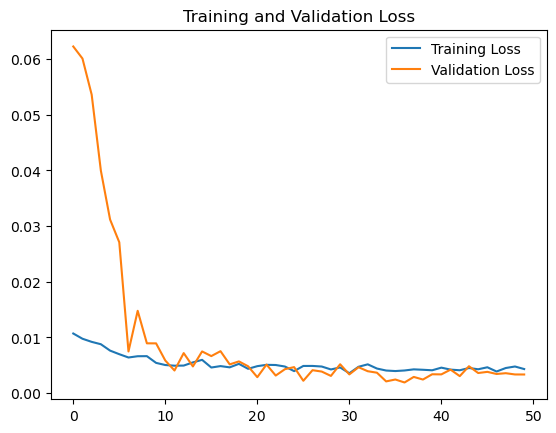

In [67]:
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


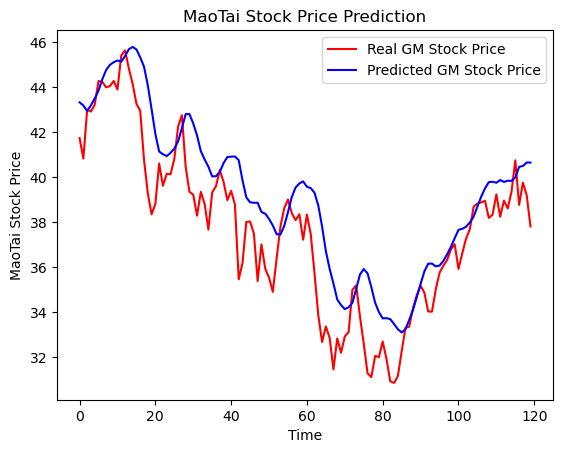

In [75]:
################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
#对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Real GM Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted GM Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()